### Wall of Imports

In [2]:
# 🔹 Standard Library Imports
import os
import getpass
import json
import shutil
import tarfile
import subprocess
import fnmatch
import functools
import operator
import uuid
import xml.etree.ElementTree as ET
from pathlib import Path
from tempfile import TemporaryDirectory
from ftplib import FTP
from typing import (
    Any, Callable, Dict, List, Optional, Tuple, TypedDict, Union, Annotated
)
import time

# 🔹 Third-Party Libraries
import requests
import pandas as pd  # Standard alias for pandas
from bs4 import BeautifulSoup
import pprint  # Useful for structured printing
from IPython.display import Image, display
from docx import Document
import pypandoc

# 🔹 LangChain Core Components
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.llms import OpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool, tool
from operator import itemgetter  # Used for extracting specific keys

# 🔹 LangChain Embeddings & Models
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai.chat_models import ChatOpenAI

# 🔹 LangChain Vector Stores & Document Loaders
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_community.document_loaders import JSONLoader, WebBaseLoader
from langchain_text_splitters import RecursiveJsonSplitter

# 🔹 LangChain Tools & Search Utilities
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools import TavilySearchResults

# 🔹 LangGraph (For Workflow Orchestration)
from langgraph.graph import END, StateGraph

# 🔹 LangChain Vector Stores
from langchain_community.vectorstores import Qdrant

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Enter API Keys

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["QDRANT_API_KEY"] = getpass.getpass("Qdrant API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

### Load Embeddings

In [4]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Connect to Qdrant Vector Store Collections

In [5]:
qdrant_url = "https://e788c0ea-f5df-4d96-85ac-350da677aadf.us-west-2-0.aws.cloud.qdrant.io"

# Opportunities
opportunities_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="opportunities",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

# Projects
projects_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="projects",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

# Opportunities Summary
opportunities_summary_qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embedding_model,
    collection_name="opportunities_summary",
    url=qdrant_url,
    api_key=os.environ["QDRANT_API_KEY"],
)

### Create Retrievers

In [6]:
opportunities_retriever = opportunities_qdrant.as_retriever(search_kwargs={"k": 30})
projects_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 10})
opportunities_summary_retriever = opportunities_summary_qdrant.as_retriever(search_kwargs={"k": 10})
projects_summary_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 10})

### Create Prompt Templates

In [7]:
study_complexity_prompt_template = """\
Use only the provided context to answer the user's question about generating budgets. You must only answer if you are specifically asked to create a budget and are
provided with one specific opportunity id or title. Do not proceed if you are missing the opportunity id or title. Use only the context for that opportunity. 
Include the opportunity id, name, award amount (from the award information section), award project period (from the award information section), and a link to the opportunity id announcement in every response. Generate the link by adding the opportunity id + .html on the end of https://grants.nih.gov/grants/guide/pa-files/ 

You must include the project complexity and the required budget form in every response to a question about project complexity or budgets.

Calculate the project complexity as follows:
1) Regulatory: (High/Medium/Low) - Rank proportionately to the number of regulations required. Provide examples supporting the score.
2) Data Collection and Management: (High/Medium/Low) - Rank proportionately to number of data elements needed (per participating site), data complexity, data sensitivity, and data collection frequency. Rank higher for more participating sites. Provide examples supporting the score.
3) Statistical Analysis and Manuscript Development: (High/Medium/Low) - Estimate the level of statistical analysis involved. Rank non-standard processes higher than standard ones. Provide examples supporting the score.
4) Information Technology: (High/Medium/Low) - Rank proportionately to IT monitoring and maintenance, software licenses and subscriptions. Rank routine services lower than non-standard services. Provide examples supporting the score.
5) Operational: (High/Medium/Low) - Rank proportionately to project administration effort required and increased site onboarding, coordination and training. Provide examples supporting the score.
6) Financial: (High/Medium/Low) - Rank proportionately to budget management complexity. Provide examples supporting the score.
        
Using only the guidance provided, determine the required budget form as follows:
1) If the application proposes the use of human fetal tissue from elective abortions, use the detailed form (R&R Budget Form).
2) Else if the direct costs (minus any consortium/subcontract F&A costs) equal more than $250,000 per year, use the detailed form (R&R Budget Form).
3) Else if the opportunity is not a research grant or cooperative agreement, use the detailed form (R&R Budget Form).
4) Else if the applicant is not based in the United States, use the detailed form (R&R Budget Form).
5) Else use the modular form (PHS 398 Modular Budget Form).

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

study_complexity_prompt = ChatPromptTemplate.from_template(study_complexity_prompt_template)

In [8]:
opportunities_rag_prompt_template = """\
Use only the provided context to answer the user's question about specific funding opportunities. You do not create budgets. If an opportunity id or title is provided, use only the context for that opportunity. 
Include the opportunity id, name, award amount (from the award information section), award project period (from the award information section), and a link to the opportunity id announcement in every response. Generate the link by adding the opportunity id + .html on the end of https://grants.nih.gov/grants/guide/pa-files/ 

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

opportunities_rag_prompt = ChatPromptTemplate.from_template(opportunities_rag_prompt_template)

In [9]:
projects_rag_prompt_template = """\
Use only the provided context to answer the user's question. If a specific project is named, use only the context for that project. Include the name of the projects in your response, and provide a link to the project details.

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

projects_rag_prompt = ChatPromptTemplate.from_template(projects_rag_prompt_template)

In [10]:
opportunities_summary_prompt_template = """\
Using only the following summarized opportunities:

    {context}

Extract the most important points and organize them into a structured table format with columns: 
"Document Number", "Title", "Activity Code", "Release Date", "Expiration Date", "URL". 
Sort the table from newest release date to oldest release date and return the table in a structured format without additional explanations.

Provide a link to the remaining funding opportunities on the NIH website here: https://grants.nih.gov/funding/nih-guide-for-grants-and-contracts
"""

opportunities_summary_prompt = ChatPromptTemplate.from_template(opportunities_summary_prompt_template)

In [11]:
projects_summary_prompt_template = """\
Using only the following summarized projects:

    {context}

Extract the most important points and organize them into a structured table format with columns: 
"Project Number", "Project Title", "Principal Investigator(s)", "Activity Code", "Award Amount", "Project Start Date", "Project End Date", "Project Detail URL". 
Sort the table from newest project start date to oldest project start date and return the table in a structured format without additional explanations.

Provide a link to the remaining projects on the NIH website here: https://reporter.nih.gov/
"""

projects_summary_prompt = ChatPromptTemplate.from_template(projects_summary_prompt_template)

### Create Model Instances

In [12]:
small_llm = ChatOpenAI(model="gpt-4o-mini")
medium_llm = ChatOpenAI(model="gpt-4o")
large_llm = ChatOpenAI(model="gpt-4-turbo")
xlarge_llm = ChatOpenAI(model="o1")

budget_llm = ChatOpenAI(model="gpt-4-turbo")
writer_llm = ChatOpenAI(model="gpt-4-turbo")

### Create Summarizers

In [14]:
summarizer_chain = load_summarize_chain(medium_llm, chain_type="map_reduce")

opportunities_summary_chain = (
    {"context": itemgetter("question") | opportunities_summary_retriever | summarizer_chain}  # Summarize retrieved docs
    | opportunities_summary_prompt  # Pass summarized context to the final prompt
    | small_llm  # Process final output
    | StrOutputParser()  # Convert to a string output
)

projects_summary_chain = (
    {"context": itemgetter("question") | projects_summary_retriever | summarizer_chain}  # Summarize retrieved docs
    | projects_summary_prompt  # Pass summarized context to the final prompt
    | small_llm  # Process final output
    | StrOutputParser()  # Convert to a string output
)

In [15]:
response = opportunities_summary_chain.invoke({"question" : "what are the most recently released funding opportunities?"})
print(response)

| Document Number       | Title                                                                 | Activity Code | Release Date | Expiration Date | URL                                                                                          |
|-----------------------|-----------------------------------------------------------------------|---------------|--------------|-----------------|----------------------------------------------------------------------------------------------|
| PAR-25-176            | Limited Competition: Small Grant Program for ORIP Special Emphasis Research Career Award (SERCA) K01 Recipients (R03 Clinical Trial Not Allowed) | R03           | 11/18/2024   | 5/8/2026        | [Link](https://grants.nih.gov/grants/guide/pa-files/PAR-25-176.html)                       |
| PAR-25-134            | Academic Research Enhancement Award (AREA) for Undergraduate-Focused Institutions (R15 Clinical Trial Not Allowed)                         | R15           | 11/26/2024   | 1/8

In [101]:
response = projects_summary_chain.invoke({"question" : "provide a list of projects with Theron Casper as one of the principal investigators"})
print(response)

| Project Number        | Project Title                                     | Principal Investigator(s)      | Activity Code | Award Amount | Project Start Date     | Project End Date       | Project Detail URL                             |
|----------------------|--------------------------------------------------|-------------------------------|---------------|--------------|------------------------|------------------------|------------------------------------------------|
| 1U24TR001597-01     | Utah Trial Innovation Center                      | Jonathan Michael Dean          | U24           | $3,622,562   | 2016-07-01             | 2023-06-30             | [Link](https://reporter.nih.gov/project-details/9142614) |
| 3U01HL094339-06S1   | THAPCA Trials - DCC Application                  | Jonathan Michael Dean          | U01           | $249,883     | 2009-03-09             | 2016-07-31             | [Link](https://reporter.nih.gov/project-details/9136934) |
| 5U01HL094339-06     | 

### Create RAG Chains

In [16]:
study_complexity_chain = (
    {"context": itemgetter("question") | opportunities_retriever, "question": itemgetter("question")}
    | study_complexity_prompt | small_llm | StrOutputParser()
)

opportunities_rag_chain = (
    {"context": itemgetter("question") | opportunities_retriever, "question": itemgetter("question")}
    | opportunities_rag_prompt | small_llm | StrOutputParser()
)

projects_rag_chain = (
    {"context": itemgetter("question") | projects_retriever, "question": itemgetter("question")}
    | projects_rag_prompt | small_llm | StrOutputParser()
)

### Test RAG Chains

In [15]:
response = study_complexity_chain.invoke({"question" : "how do I create a budget for funding opportunity PA-25-147"})
pprint.pprint(response)

('Here is the budget information for funding opportunity **PA-25-147: NIDDK '
 'High Risk Multi-Center Clinical Study Cooperative Agreement (U01 Clinical '
 'Trial Required)**:\n'
 '\n'
 '- **Opportunity ID**: PA-25-147\n'
 '- **Name**: NIDDK High Risk Multi-Center Clinical Study Cooperative '
 'Agreement (U01 Clinical Trial Required)\n'
 '- **Award Amount**: Not specified in the provided context.\n'
 '- **Award Project Period**: Not specified in the provided context.\n'
 '- **Link to Opportunity Announcement**: [PA-25-147 '
 'Announcement](https://grants.nih.gov/grants/guide/pa-files/PA-25-147.html)\n'
 '\n'
 '### Project Complexity:\n'
 '1. **Regulatory**: Medium - Involves standard clinical trial regulations but '
 'may also have additional requirements due to multisite nature.\n'
 '2. **Data Collection and Management**: High - Likely involves multiple data '
 'elements from various sites, requiring rigorous data management protocols.\n'
 '3. **Statistical Analysis and Manuscript De

In [216]:
projects_rag_chain.invoke({"question" : "summarize the University of Utah projects by year"})

'### University of Utah Projects by Year\n\n#### 2010\n- **Project Title:** Population Assessment of Young Children with Spina Bifida in Utah\n  - **Objective:** Develop a longitudinal, population-based cohort of children with spina bifida to understand secondary conditions impacting their health and well-being.\n  - **Award Amount:** $299,509\n  - **[Project Details](https://reporter.nih.gov/project-details/8036930)**\n\n#### 2018\n- **Project Title:** University of Utah Center of Excellence in ELSI Research: UCEER\n  - **Objective:** Focus on population screening for genetic conditions affecting women, children, and families, enhancing education and informed decision-making.\n  - **Award Amount:** $966,064\n  - **[Project Details](https://reporter.nih.gov/project-details/9488529)**\n\n#### 2019\n- **Project Title:** University of Utah Center of Excellence in ELSI Research: UCEER\n  - **Objective:** Continuation of ELSI research focused on population-based genetic testing and screenin

### Create RAG Tools

In [17]:
@tool
def assess_study_complexity(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to get information about NIH funding opportunities and assess study complexity"""
  return study_complexity_chain.invoke({"question" : query})

@tool
def retrieve_opportunities_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to get information about NIH funding opportunities"""
  return opportunities_rag_chain.invoke({"question" : query})

@tool
def retrieve_projects_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about NIH projects"""
  return projects_rag_chain.ainvoke({"question" : query})

### Create Summarize Tools

In [18]:
@tool
def summarize_opportunities(
    query: Annotated[str, "query to ask the summarize opportunities tool"]
    ):
  """Use summarize tool to summarize NIH funding opportunities"""
  return opportunities_summary_chain.invoke({"question" : query})

@tool
def summarize_projects(
    query: Annotated[str, "query to ask the summarize projects tool"]
    ):
  """Use summarize tool to summarize NIH projects"""
  return projects_summary_chain.invoke({"question" : query})

### Create Search Tools

In [19]:
pub_med_tool = PubmedQueryRun()
tavily_tool = TavilySearchResults(
    max_results=5,
    include_answer=True,
    include_raw_content=True
)

### Create Budget Analysis Tools

In [20]:
@tool
def do_nothing(
    input_text: Annotated[str, "Any input text."]
) -> Annotated[str, "A placeholder response indicating the tool does nothing."]:
    """
    A LangChain tool that does nothing and returns a generic response.
    Useful as a placeholder for debugging or tool testing.
    """
    return "This tool does nothing. You provided: " + input_text

@tool
def calculate_person_months(percentage: float) -> float:
    """Calculates person months by multiplying a given percentage by 12 and returns the result."""
    return percentage/100 * 12

### Create Document Tools

In [21]:
budget_directory = 'data/Documents/Budget Documents'

os.makedirs(budget_directory, exist_ok=True)

'''
def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('data/Documents', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path
'''

WORKING_DIRECTORY = Path(budget_directory)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

@tool
def combine_text_files(directory: str, output_filename: str = "FinalBudgetProposal.txt"):
    """Combines all text files in the given directory into a single file."""
    output_path = os.path.join(directory, output_filename)
    horizontal_rule = "----------------------------------------------------------------------------------------------------------------------------------------------"

    with open(output_path, "w", encoding="utf-8") as outfile:
        for filename in sorted(os.listdir(directory)):  # Sort files for consistency
            if filename.endswith(".txt") and filename != output_filename:  # Avoid merging output file itself
                file_path = os.path.join(directory, filename)
                with open(file_path, "r", encoding="utf-8") as infile:
                    outfile.write(filename.replace(".txt", "") + "\n" + horizontal_rule + "\n\n")
                    outfile.write(infile.read() + "\n\n")  # Add spacing between files

@tool
def save_text_as_markdown(directory: str, text_filename: str = 'FinalBudgetProposal.txt', md_filename: str = "FinalBudgetProposal.md"):
    """Reads a text file and saves it as a Markdown (.md) file."""
    output_path = os.path.join(directory, md_filename)
    input_path = os.path.join(directory, text_filename)

    # 🔹 Read the Text File
    with open(input_path, "r", encoding="utf-8") as txt_file:
        text_content = txt_file.read()

    # 🔹 Convert to Markdown (Basic Formatting)
    markdown_content = f"{text_content}"

    # 🔹 Save as Markdown File
    with open(output_path, "w", encoding="utf-8") as md_file:
        md_file.write(markdown_content)

@tool
def convert_markdown_to_pdf_using_pdfkit(directory: str, md_filename: str = "FinalBudgetProposal.md", pdf_filename: str = "FinalBudgetProposal.pdf"):
    """Converts Markdown content to PDF using pdfkit."""
    output_path = os.path.join(directory, pdf_filename)
    input_path = os.path.join(directory, md_filename)
    max_retries = 5
    retry_delay = 2  # seconds

    extra_args = [
    "--pdf-engine=xelatex",  # Use XeLaTeX for better font support
    "-V", "geometry:margin=1in",  # Set margins (1 inch)
    "-V", "geometry:letterpaper",  # Set paper size (A4)
    "-V", "geometry:landscape",  # Set orientation (landscape)
    ]
    
    for attempt in range(max_retries):
        try:
            pypandoc.convert_file(input_path, "pdf", extra_args=extra_args, outputfile=output_path)
            return f"PDF saved to {output_path}"
        except Exception as e:
            if attempt < max_retries - 1:  # Not the last attempt
                time.sleep(retry_delay)

@tool
def convert_txt_to_docx(directory: str, txt_file: str = "FinalBudgetProposal.txt", docx_file: str = "FinalBudgetProposal.docx"):
    """Converts a .txt file to a .docx file."""
    output_path = os.path.join(directory, docx_file)
    input_path = os.path.join(directory, txt_file)
    
    # 🔹 Read text file
    with open(input_path, "r", encoding="utf-8") as file:
        text = file.read()

    # 🔹 Create a new Word document
    doc = Document()
    doc.add_paragraph(text)  # Add text as a paragraph

    # 🔹 Save as .docx
    doc.save(output_path)

@tool
def remove_text_files(directory: str):
    """Removes all .txt files from the specified directory."""
    
    # 🔹 Check if directory exists
    if not os.path.isdir(directory):
        print(f"❌ Error: Directory '{directory}' does not exist.")
        return
    
    removed_files = 0

    # 🔹 Iterate through files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # 🔹 Check if it's a .txt file and delete it
        if filename.endswith(".txt") and os.path.isfile(file_path):
            os.remove(file_path)
            removed_files += 1
            print(f"🗑️ Deleted: {filename}")

    if removed_files == 0:
        print("✅ No .txt files found in the directory.")
    else:
        print(f"✅ Removed {removed_files} .txt files from '{directory}'.")

### Async Helper Functions

In [22]:
async def aagent_node(state, agent: Runnable, name: str):
    """Runs an agent asynchronously and returns a new message."""
    result = await agent.ainvoke(state)  # Async agent invocation
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# 🔹 Make create_agent Async
async def acreate_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> AgentExecutor:
    """Create a function-calling agent asynchronously and add it to the graph."""
    system_prompt += (
        "\nWork with just the tools available to you and no others."
        " Do not ask for clarification or feedback."
        " Trust in the tools provided to you and their output."
        " Your other team members (and other teams) will collaborate with you with their own specialties."
        " You are one of the following team members: {team_members}."
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_functions_agent(llm, tools, prompt)

    # ✅ Async-compatible agent executor
    executor = AgentExecutor(agent=agent, tools=tools, force_tool=True, cache=None)

    return executor


# 🔹 Make create_team_supervisor Async
async def acreate_team_supervisor(llm: ChatOpenAI, system_prompt: str, members: list):
    """An LLM-based router that asynchronously selects the next team member to act."""
    options = ["FINISH"] + members

    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [{"enum": options}],
                },
            },
            "required": ["next"],
        },
    }

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))

    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Non-Async Helper Functions

In [23]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork with just the tools available to you and no others."
    " Do not ask for clarification or feedback."
    " Trust in the tools provided to you and their output."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, force_tool=True, cache=None)
    return executor

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Initialize Research Team State

In [24]:
class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

### Create Agents

In [25]:
budgets_prompt = '''
You are a research assistant who only helps with generating budgets for specific funding opportunities. 
You must use the assess_study_complexity tool to assess study complexity and include it in your response.
You must provide all of the output from the assess_study_complexity tool. Do not summarize and do not leave anything out of your response.
You must only respond with information about the funding opportunities related to the request. 
'''

budgets_agent = await acreate_agent(
    large_llm,
    [assess_study_complexity],
    budgets_prompt,
)
budgets_node = functools.partial(agent_node, agent=budgets_agent, name="BudgetGenerator")

In [26]:
opportunities_prompt = '''
You are a research assistant who helps with questions about specific funding opportunities.
You must use the retrieve_opportunities_information tool to respond to questions.
You must only respond with information about the funding opportunities related to the request. 
'''

opportunities_agent = await acreate_agent(
    large_llm,
    [retrieve_opportunities_information],
    opportunities_prompt,
)
opportunities_node = functools.partial(agent_node, agent=opportunities_agent, name="OpportunitiesInformationRetriever")

In [27]:
projects_prompt = '''
You are a research assistant who can provide specific information about individual NIH projects. 
You must use the retrieve_projects_information tool to retrieve information related to the question.
You must only respond with information about the projects related to the request. 
You must use all of the output the from retrieve_projects_information tool. Do not summarize. 
'''

projects_agent = create_agent(
    small_llm,
    [retrieve_projects_information],
    projects_prompt,
)
projects_node = functools.partial(agent_node, agent=projects_agent, name="ProjectsInformationRetriever")

In [28]:
publications_prompt = '''
You are a research assistant who can provide specific information on NIH publications. 
You do not respond to requests about budgets or study complexity.
You must only respond with information about the publications related to the request. 
In addition to your main response, include the publication title, author, publication date, and link. 
'''

publications_agent = create_agent(
    small_llm,
    [pub_med_tool],
    publications_prompt,
)
publications_node = functools.partial(agent_node, agent=publications_agent, name="PublicationSearch")

In [29]:
search_prompt = '''
You are a research assistant who can search the internet for additional support for your team. 
You do not respond to requests about budgets or study complexity.
You must first give your other teammates a chance to respond. 
When it's your turn, you must only respond with information related to the request. 
In addition to your main response, include a link to your source. 
'''

search_agent = create_agent(
    small_llm,
    [tavily_tool],
    search_prompt,
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [30]:
opportunities_summary_prompt = '''
You are a research assistant who can summarize information about NIH funding opportunities.
You do not respond to requests about budgets or study complexity.
You must use the summarize_opportunitiestool to retrieve information related to the question.
You must only respond with information about the funding opportunities related to the request. 
You must use all of the output the from summarize_opportunities tool. Do not summarize. 
'''

opportunities_summary_agent = create_agent(
    small_llm,
    [summarize_opportunities],
    opportunities_summary_prompt,
)
opportunities_summary_node = functools.partial(agent_node, agent=opportunities_summary_agent, name="OpportunitiesSummary")

In [31]:
projects_summary_prompt = '''
You are a research assistant who can summarize information about NIH projects.
You do not respond to requests about budgets or study complexity.
You must use the summarize_projects tool to retrieve information related to the question.
You must only respond with information about the projects related to the request. 
You must use all of the output the from summarize_projects tool. Do not summarize. 
'''

projects_summary_agent = create_agent(
    small_llm,
    [summarize_projects],
    projects_summary_prompt,
)
projects_summary_node = functools.partial(agent_node, agent=projects_summary_agent, name="ProjectsSummary")

In [32]:
general_requests_prompt = '''
You are a research assistant who responds to general requests. You give your other teammates a chance to respond first.
When it's your turn, you must only respond with information related to the request. 
'''

general_requests_agent = create_agent(
    small_llm,
    [do_nothing],
    general_requests_prompt,
)
general_requests_node = functools.partial(agent_node, agent=general_requests_agent, name="GeneralRequests")

In [33]:
supervisor_agent_prompt = '''
You are a supervisor tasked with managing a conversation between the following workers: 
Search, OpportunitiesSummary, ProjectsSummary, OpportunitiesInformationRetriever, ProjectsInformationRetriever, PublicationSearch, BudgetGenerator, GeneralRequests. 
Given the following user request, determine the content type to be researched and respond with the worker to act next. Each worker will perform a 
task and respond with their results and status. You should never ask your team to do anything beyond research. They are not required to write content or posts.
You trust in your workers and the tools they are using to do their work, providing guidance as needed.
You should only pass tasks to workers that are specifically research focused.
Give each worker only one chance to complete their task.
When all workers are finished, respond with FINISH.
'''

supervisor_agent = create_team_supervisor(
    large_llm,
    supervisor_agent_prompt,
    ["Search", "OpportunitiesSummary", "ProjectsSummary", "OpportunitiesInformationRetriever", "ProjectsInformationRetriever", "PublicationSearch", "BudgetGenerator", "GeneralRequests"],
)

/var/folders/mn/0my2dcr50j3g01czsw6gr97w0000gn/T/ipykernel_48757/1137669147.py:63: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [35]:
personnel_effort_prompt = '''
You are an expert at calculating NIH personnel budgets. 
You use the provided study complexity and project duration to estimate the effort allocation percentage per year for different roles on the project team. 
Those roles include:

Key Personnel:
- DCC Principal Investigator (Required): Min 15% per year

Other Personnel:
- DCC Co-Principal Investigator (Optional): Min 15%
- Clinical Data Manager(s) (1 Required): Min 60%
- Statistician(s) (1 Required): Min 50%
- Clinical Project Manager (Required): Min 75%
- Business Project Manager (Required): Min 25% at start and then phase out
- Software Engineering (Optional): Depends on software development requirements and includes phase out
- IT Project Manager (Optional): Depeneds on software development requirements and includes phase out
- IT Operations (Required): Min 0%
- Ops Leader (Required): Min 10%
- Administrative Program Coordinator (Required): Min 10%
- Regulatory and Quality Assurance Manager (Optional): Min 5%
- Finance (Required): Min 5%
- Medical Monitor (Optional): Only if a medical monitor is required
- Business Intelligence (Optional): Depends on reporting requirements and includes phase out
- Biometrics Management (Required): Min 5%
- Clinical Project Manager Management (Required): Min 5%
- IT Management (Required): Depends on software development requirements

Use the calculate_person_months tool to calculate person months in addition to effort allocations.
Display both the effort allocation % and calculated person months in a table with the roles listed in rows and the study years listed in columns. You must include both the effort allocation % and person months.

Your work is complete after this table is created.
'''

personnel_effort_agent = await acreate_agent(
    budget_llm,
    [calculate_person_months],
    personnel_effort_prompt,
)
personnel_effort_node = functools.partial(
    agent_node, agent=personnel_effort_agent, name="PersonnelEffort"
)

personnel_justifications_prompt = '''
You are an expert at creating NIH personnel budget justifications. You use the effort allocation estimates produced by your PersonnelEffort team member
to create a comprehensive justification summary for each role on the project. 

The personnel justification should include the name, role, number of person-months devoted to this project, and justification for every person on the project. 
The justification should cover the full scope of responsibilities along with impact on the study. 
Do not include salary and fringe benefit rate in the justification.

Your work is complete after a justification is created for each role on the project.
'''

personnel_justifications_agent = await acreate_agent(
    budget_llm,
    [do_nothing],
    personnel_justifications_prompt,
)
personnel_justifications_node = functools.partial(
    agent_node, agent=personnel_justifications_agent, name="PersonnelJustifications"
)

nonpersonnel_costs_prompt = '''
You are an expert at calculating NIH non-personnel budgets. You use the provided study complexity and project duration to estimate 
the total cost per category listed below for the entire duration of the project. 

Equipment, Travel, and Trainee Costs:
- Equipment (average $0 per year): Equipment is defined as an item of property that has an acquisition cost of $5,000 or more (unless the organization has established lower levels) and an expected service life of more than one year. 
- Travel (average $15000-20000 per year): In the budget justification, include the destination, number of people traveling and dates or duration of your stay for all anticipated travel. 
- Trainee Costs (average $0 per year): Leave this section blank unless otherwise stated in the funding opportunity. 

Other Direct Costs:
- Materials and Supplies (average $2000 per year): Includes items like general-use laptops, software licensing, printing and photocopying, and shipping and freight.
- Site Monitoring (average $4000-5000 per year): Includes costs for site monitoring and increases proportionately to the number of participating sites.
- Data and Safety Monitoring Board (average $5000-6000 per year): Includes costs related to DSMB requirements.
- Single/Multiple IRB (average $10000-15000 per year): Includes costs related to the IRB requirements.
- Publication Costs (average $3000-4000 per year): Costs associated with helping disseminate research findings. 
- Consultant Services (average $0 per year): Costs associated with consultants who provide advice but do not make decisions for the direction of the research. 
- ADP/Computer Services (average $0 per year): Costs for research specific computer services- such as reserving computing time on supercomputers or getting specialized software to help run your statistics.
- Alterations and Renovations (average $0 per year): Not typically included but covers costs for any alteration or renovation required.
- Research Patient Care Costs (average $0 per year): Not typically included but covers costs for patient care expenses.
- Tuition (average $0 per year): Not typically included but covers costs for graduate students contributing to the project.
- Human Fetal Tissue from elective abortions (average $0 per year): Not typically included but covers costs for the use of human fetal tissue obtained from elective abortions.
- Other (average $0 per year): Any other allowable costs not accounted for in the previous sections.

Display the total dollar amounts for all years combined in a table with the categories listed in rows and the total dollar amounts listed in a single column. Do not display the total dollar amounts as a range.
Include a total for all years and categories combined.

Your work is complete after this table is created.
'''

nonpersonnel_costs_agent = await acreate_agent(
    budget_llm,
    [do_nothing],
    nonpersonnel_costs_prompt,
)
nonpersonnel_costs_node = functools.partial(
    agent_node, agent=nonpersonnel_costs_agent, name="NonPersonnelCosts"
)

nonpersonnel_justifications_prompt = '''
You are an expert at creating NIH non-personnel budget justifications. You use the non-personnel cost estimates produced by your NonPersonnelCosts team member
to create a comprehensive justification summary for each category in the project. 

The non-personnel costs justification should include the category name, total dollar amount, and justification for every category listed.
The justification should cover the full description of the category along with impact on the study. 

Your work is complete after a justification is created for each role on the project.
'''

nonpersonnel_justifications_agent = await acreate_agent(
    budget_llm,
    [do_nothing],
    nonpersonnel_justifications_prompt,
)
nonpersonnel_justifications_node = functools.partial(
    agent_node, agent=nonpersonnel_justifications_agent, name="NonPersonnelJustifications"
)

In [36]:
study_complexity_writer_prompt = '''
You are an expert at writing study complexity documents related to generating a budget. 
Write all of the provided study complexity and funding opportunity details to a text document titled 1_Funding_Opportunity_Overview.txt, overwriting the old document as needed. 
Make formatting changes as needed to make the document more readable but do not change the overall content. 
'''

study_complexity_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    study_complexity_writer_prompt,
)
#context_aware_personnel_effort_writer_agent = prelude | personnel_effort_writer_agent
study_complexity_writer_node = functools.partial(
    agent_node, agent=study_complexity_writer_agent, name="StudyComplexityWriter"
)

personnel_effort_writer_prompt = '''
You are an expert writing personnel effort documents. You may only use the information passed to you to write the entire provided context to a text document titled 2_Personnel_Effort.txt, 
overwriting the old document as needed. You must include all of the information from the PersonnelEffort table. Do not make any changes.
'''

personnel_effort_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    personnel_effort_writer_prompt,
)
#context_aware_personnel_effort_writer_agent = prelude | personnel_effort_writer_agent
personnel_effort_writing_node = functools.partial(
    agent_node, agent=personnel_effort_writer_agent, name="PersonnelEffortWriter"
)

personnel_justification_writer_prompt = '''
You are an expert writing personnel justification documents. You may only use the information passed to you to write the entire provided context to a text document titled 4_Personnel_Justification.txt, 
overwriting the old document as needed. You must include all of the information from the PersonnelJustifications team member. Do not make any changes.
'''

personnel_justification_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    personnel_justification_writer_prompt,
)
#context_aware_personnel_justification_writer_agent = prelude | personnel_justification_writer_agent
personnel_justification_writing_node = functools.partial(
    agent_node, agent=personnel_justification_writer_agent, name="PersonnelJustificationWriter"
)

nonpersonnel_costs_writer_prompt = '''
You are an expert writing non-personnel costs documents. You may only use the information passed to you to write the entire provided context to a text document titled 5_Non-Personnel_Costs.txt, 
overwriting the old document as needed. You must include all of the information from the NonPersonnelCosts team member. Do not make any changes.
'''

nonpersonnel_costs_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    nonpersonnel_costs_writer_prompt,
)
#context_aware_nonpersonnel_effort_writer_agent = prelude | nonpersonnel_costs_writer_agent
nonpersonnel_costs_writing_node = functools.partial(
    agent_node, agent=nonpersonnel_costs_writer_agent, name="NonPersonnelCostsWriter"
)

nonpersonnel_justification_writer_prompt = '''
You are an expert writing non-personnel budget justification documents. You may only use the information passed to you to write the entire provided context to a text document titled 6_Non-Personnel_Justification.txt, 
overwriting the old document as needed. You must include all of the information from the NonPersonnelJustifications team member. Do not make any changes.
'''

nonpersonnel_justification_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    nonpersonnel_justification_writer_prompt,
)
#context_aware_nonpersonnel_justification_writer_agent = prelude | nonpersonnel_justification_writer_agent
nonpersonnel_justification_writing_node = functools.partial(
    agent_node, agent=nonpersonnel_justification_writer_agent, name="NonPersonnelJustificationWriter"
)

final_budget_writer_prompt = '''
You are an expert at combining documents. You use the combine_text_files tool to create a new combined document called FinalBudgetProposal.txt in the data/Documents/Budget Documents directory.
'''

final_budget_writer_agent = await acreate_agent(
    medium_llm,
    [combine_text_files],
    final_budget_writer_prompt,
)
final_budget_writer_node = functools.partial(
    agent_node, agent=final_budget_writer_agent, name="FinalBudgetWriter"
)

dopifier_writer_prompt = '''
You are an expert at converting text documents to PDF documents. 
You first use the save_text_as_markdown tool to convert the final budget proposal document to a FinalBudgetProposal.md markdown file in the data/Documents/Budget Documents directory.
You then use the convert_markdown_to_pdf_using_pdfkit tool to convert the final budget proposal markdown file to a FinalBudgetProposal.pdf file in the data/Documents/Budget Documents directory.
'''

dopifier_writer_agent = await acreate_agent(
    medium_llm,
    [save_text_as_markdown, convert_markdown_to_pdf_using_pdfkit],
    dopifier_writer_prompt,
)
dopifier_writer_node = functools.partial(
    agent_node, agent=dopifier_writer_agent, name="Dopifier"
)

In [37]:
@tool
def calculate_person_dollars(percentage: float, salary: float, benefits: float) -> float:
    """Calculates person dolloars by multiplying a given percentage by the salary and returns the result."""
    if percentage > 1:
        percentage = percentage/100
    
    if benefits > 1:
        benefits = benefits/100
    
    return percentage*salary+percentage*benefits

personnel_costs_prompt = '''
You are an expert at creating NIH personnel costs. You use the effort allocation estimates (not the person months) produced by your PersonnelEffort team member
to create a comprehensive costs table for each role on the project. Each role has an assumed salary and benefits % that you must use to calculate the total personnel costs. 
The total benefits % is 15%, and the total salary for each role is as follows:

Key Personnel:
- DCC Principal Investigator (Required): $150,000

Other Personnel:
- DCC Co-Principal Investigator: $125,000
- Clinical Data Manager: $80,000
- Statistician(s) (1 Required): $80,000
- Clinical Project Manager: $80,000
- Business Project Manager: $80,000
- Software Engineering: $90,000
- IT Project Manager: $80,000
- IT Operations: $80,000
- Ops Leader: $100,000
- Administrative Program Coordinator: $60,000
- Regulatory and Quality Assurance Manager: $80,000
- Finance: $80,000
- Medical Monitor: $80,000
- Business Intelligence: $80,000
- Biometrics Management: $100,000
- Clinical Project Manager Management: $100,000
- IT Management: $100,000

Use the calculate_person_dollars tool to calculate total personnel costs.
Display both the effort allocation % and calculated costs in a comprehensive table with all the roles listed in rows and all the study years listed in columns. You must include all the same rows as the PersonnelEffort table.
Include subtotals for each year and for each role.

You may explain the calculation in simple terms but do not include the equation in your response.

Your work is complete after a table is created.
'''

personnel_costs_agent = await acreate_agent(
    budget_llm,
    [calculate_person_dollars],
    personnel_costs_prompt,
)
personnel_costs_node = functools.partial(
    agent_node, agent=personnel_costs_agent, name="PersonnelCosts"
)

personnel_costs_writer_prompt = '''
You are an expert writing personnel costs documents. You may only use the information passed to you to write the entire provided context to a text document titled 3_Personnel_Costs.txt, 
overwriting the old document as needed. Do not make any changes.
'''

personnel_costs_writer_agent = await acreate_agent(
    writer_llm,
    [write_document, edit_document, read_document],
    personnel_costs_writer_prompt,
)
#context_aware_nonpersonnel_effort_writer_agent = prelude | nonpersonnel_costs_writer_agent
personnel_costs_writing_node = functools.partial(
    agent_node, agent=personnel_costs_writer_agent, name="PersonnelCostsWriter"
)

### Configure Graph

In [38]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("OpportunitiesInformationRetriever", opportunities_node)
research_graph.add_node("BudgetGenerator", budgets_node)
research_graph.add_node("supervisor", supervisor_agent)
research_graph.add_node("PersonnelEffort", personnel_effort_node)
research_graph.add_node("PersonnelEffortWriter", personnel_effort_writing_node)
research_graph.add_node("PersonnelJustifications", personnel_justifications_node)
research_graph.add_node("PersonnelJustificationWriter", personnel_justification_writing_node)
research_graph.add_node("NonPersonnelCosts", nonpersonnel_costs_node)
research_graph.add_node("NonPersonnelCostsWriter", nonpersonnel_costs_writing_node)
research_graph.add_node("NonPersonnelJustifications", nonpersonnel_justifications_node)
research_graph.add_node("NonPersonnelJustificationWriter", nonpersonnel_justification_writing_node)
research_graph.add_node("ProjectsInformationRetriever", projects_node)
research_graph.add_node("PublicationSearch", publications_node)
research_graph.add_node("Search", search_node)
research_graph.add_node("OpportunitiesSummary", opportunities_summary_node)
research_graph.add_node("ProjectsSummary", projects_summary_node)
research_graph.add_node("StudyComplexityWriter", study_complexity_writer_node)
research_graph.add_node("FinalBudgetWriter", final_budget_writer_node)
research_graph.add_node("Dopifier", dopifier_writer_node)
research_graph.add_node("GeneralRequests", general_requests_node)
research_graph.add_node("PersonnelCosts", personnel_costs_node)
research_graph.add_node("PersonnelCostsWriter", personnel_costs_writing_node)

In [39]:
research_graph.add_edge("OpportunitiesInformationRetriever", "supervisor")
research_graph.add_edge("ProjectsInformationRetriever", "supervisor")
research_graph.add_edge("OpportunitiesSummary", "supervisor")
research_graph.add_edge("ProjectsSummary", "supervisor")
research_graph.add_edge("PublicationSearch", "supervisor")
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("BudgetGenerator", "PersonnelEffort")
research_graph.add_edge("BudgetGenerator", "NonPersonnelCosts")
research_graph.add_edge("BudgetGenerator", "StudyComplexityWriter")
research_graph.add_edge("PersonnelEffort", "PersonnelEffortWriter")
research_graph.add_edge("PersonnelEffort", "PersonnelJustifications")
research_graph.add_edge("PersonnelJustifications", "PersonnelJustificationWriter")
research_graph.add_edge("NonPersonnelCosts", "NonPersonnelCostsWriter")
research_graph.add_edge("NonPersonnelCostsWriter", "FinalBudgetWriter")
research_graph.add_edge("PersonnelJustificationWriter", "FinalBudgetWriter")
research_graph.add_edge("PersonnelEffortWriter", "FinalBudgetWriter")
research_graph.add_edge("NonPersonnelCosts", "NonPersonnelJustifications")
research_graph.add_edge("NonPersonnelJustifications", "NonPersonnelJustificationWriter")
research_graph.add_edge("NonPersonnelJustificationWriter", "FinalBudgetWriter")
research_graph.add_edge("StudyComplexityWriter", "FinalBudgetWriter")
research_graph.add_edge("FinalBudgetWriter", "Dopifier")
research_graph.add_edge("Dopifier", END)
research_graph.add_edge("BudgetGenerator", "supervisor")
research_graph.add_edge("GeneralRequests", "supervisor")
research_graph.add_edge("PersonnelEffort", "PersonnelCosts")
research_graph.add_edge("PersonnelCosts", "PersonnelCostsWriter")
research_graph.add_edge("PersonnelCostsWriter", "FinalBudgetWriter")

research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"BudgetGenerator": "BudgetGenerator", "OpportunitiesInformationRetriever": "OpportunitiesInformationRetriever", "ProjectsInformationRetriever": "ProjectsInformationRetriever",
     "PublicationSearch": "PublicationSearch", "Search": "Search", "OpportunitiesSummary": "OpportunitiesSummary", "ProjectsSummary": "ProjectsSummary", "GeneralRequests": "GeneralRequests", "FINISH": END},
)

In [40]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

### Display Graph Image

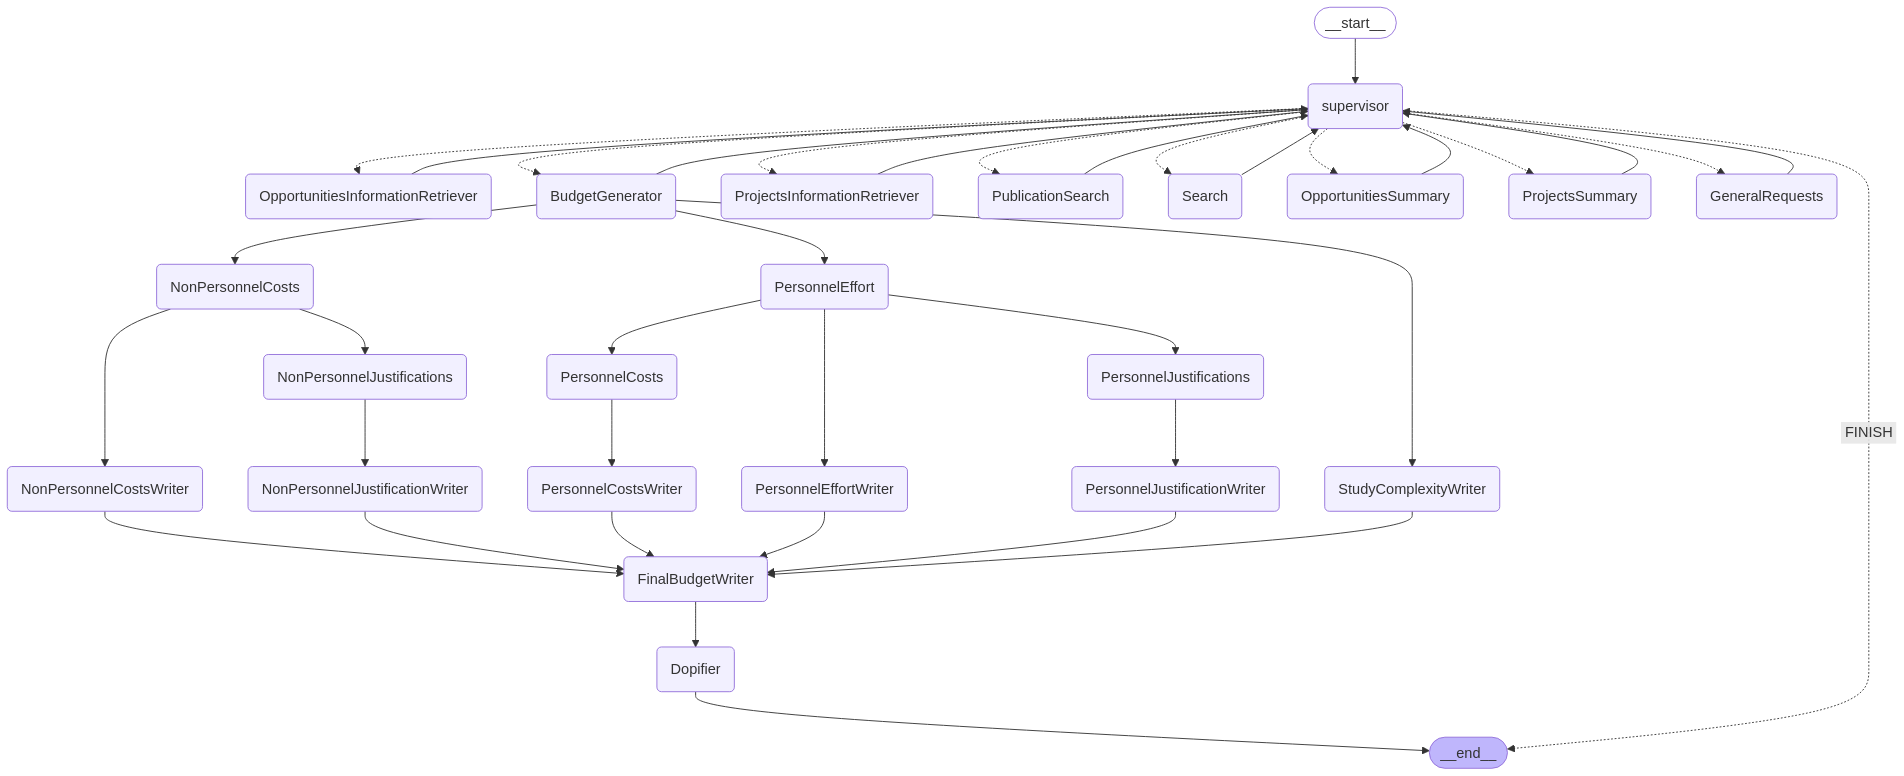

In [41]:
try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Configure Team Members

In [42]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(research_graph.nodes),
    }
    return results

research_chain = enter_chain | chain

### Test Chain

In [53]:
result = await chain.ainvoke({"messages": [HumanMessage(content="I need help with my grant application")], "team_members": ", ".join(research_graph.nodes)})
print(result['messages'][-1].content)

Here are some NIH funding opportunities that may assist with your grant application:

1. **Limited Competition: Small Grant Program for NHLBI K01/K08/K23/K25 Recipients**
   - **Activity Code:** R03
   - **Release Date:** 12/16/2024
   - **Expiration Date:** 1/8/2026
   - [Link](https://grants.nih.gov/grants/guide/rfa-files/RFA-HL-25-011.html)

2. **Limited Competition: Small Grant Program for NIDDK K01/K08/K23/K25 Recipients**
   - **Activity Code:** R03
   - **Release Date:** 1/10/2025
   - **Expiration Date:** 1/8/2028
   - [Link](https://grants.nih.gov/grants/guide/pa-files/PAR-25-091.html)

3. **Revision Applications for Incorporation of Novel NCI-Supported Technology to Accelerate Cancer Research**
   - **Activity Code:** U01
   - **Release Date:** 12/31/2024
   - **Expiration Date:** 10/4/2025
   - [Link](https://grants.nih.gov/grants/guide/rfa-files/RFA-CA-25-006.html)

4. **Limited Competition: Building Partnerships and Broadening Perspectives to Advance Ethical, Legal, and So

In [64]:
# generate a budget for funding opportunity PAR-25-283

for s in research_chain.stream(
    "what can you do?", {"recursion_limit": 10}
):
    if "__end__" not in s:
        for key in s:
            if key != 'supervisor':
                print(s[key]['messages'][-1].content)
        '''if 'supervisor' in s and 'next' in s['supervisor']:
            print(s['supervisor']['next'])
        elif 'GeneralRequests' in s and 'messages' in s['GeneralRequests']:
            print(s['GeneralRequests']['messages'][-1].content)
        else:'''

I can assist with general requests related to research assistance, including finding information, generating budgets, writing personnel justifications, and more. If you have a specific request, feel free to ask!


In [65]:
content = "Processing your request... This may take a few minutes."
tokens = content.split()
print(content)
print(tokens)

Processing your request... This may take a few minutes.
['Processing', 'your', 'request...', 'This', 'may', 'take', 'a', 'few', 'minutes.']
